In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    matthews_corrcoef, cohen_kappa_score, roc_curve, auc
)
import seaborn as sns
from matplotlib.patches import Patch


In [2]:
features = pd.read_csv('CS4824CapstoneData/features_grid.csv')

fips  year  centroid_lat  centroid_lon  infested  tree_of_heaven  \
0  1001  2014      32.53492    -86.642749         0               1   
1  1001  2015      32.53492    -86.642749         0               1   
2  1001  2016      32.53492    -86.642749         0               1   
3  1001  2017      32.53492    -86.642749         0               1   
4  1001  2018      32.53492    -86.642749         0               1   

   urban_code  urban_effective  spatial_lag  
0         3.0                0          0.0  
1         3.0                0          0.0  
2         3.0                0          0.0  
3         3.0                0          0.0  
4         3.0                0          0.0

In [ ]:
features.head()

In [4]:
#Train split 2014-2023
train_data = features[features['year'] <= 2023].copy()

# Test split 2024-2025
test_data = features[features['year'].isin([2024, 2025])].copy()

print(f"\nTrain data: {len(train_data)} records")
print(f"Test data: {len(test_data)} records")

print(f"\nTrain class distribution:")
print(train_data['infested'].value_counts())
print(f"\nTest class distribution:")
print(test_data['infested'].value_counts())



Train data: 31090 records
Test data: 6218 records

Train class distribution:
infested
0    30447
1      643
Name: count, dtype: int64

Test class distribution:
infested
0    5672
1     546
Name: count, dtype: int64


In [5]:
#Calculate class weights
n_neg = (train_data['infested'] == 0).sum()
n_pos = (train_data['infested'] == 1).sum()
scale_pos_weight = n_neg / n_pos

print(f"Scale_pos_weight: {scale_pos_weight:.2f}")

Scale_pos_weight: 47.35


In [6]:
#Prediction thresholds
#model must be 70% confident the county is infested
PREDICTION_THRESHOLD = 0.7

#for spatial lag model, 40% of neighboring counties must be infested
SPATIAL_LAG_THRESHOLD = 0.4

In [7]:
#feature sets

# Model 1: environmental features only
model1_features = ['year', 'tree_of_heaven', 'urban_code', 'urban_effective']

# Model 2: environmental + coordinates
model2_features = ['year', 'tree_of_heaven', 'urban_code', 'urban_effective',
                   'centroid_lat', 'centroid_lon']

# Model 3: environmental + spatial lag
model3_features = ['year', 'tree_of_heaven', 'urban_code', 'urban_effective',
                   'spatial_lag']

In [8]:
#evaluation metrics

def evaluate_model(y_true, y_pred, y_pred_proba, model_name):

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    #confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()


    print(f"\n{'Metric':<30} {'Value':<10}")
    print(f"{'Accuracy':<30} {accuracy:.4f}")
    print(f"{'Precision':<30} {precision:.4f}")
    print(f"{'Recall (Sensitivity/TPR)':<30} {recall:.4f}")
    print(f"{'F1-Score':<30} {f1:.4f}")
    print(f"{'ROC-AUC':<30} {roc_auc:.4f}")
    print(f"{'Matthews Correlation Coef':<30} {mcc:.4f}")
    print(f"{'Cohen Kappa':<30} {kappa:.4f}")

    print(f"\n{'Confusion Matrix':<30}")
    print(f"True Negatives:  {tn:>6}")
    print(f"False Positives: {fp:>6}")
    print(f"False Negatives: {fn:>6}")
    print(f"True Positives:  {tp:>6}")

    print(f"\n{'Classification Report':<30}")
    print(classification_report(y_true, y_pred, target_names=['Not Infested', 'Infested']))


    metrics = {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'mcc': mcc,
        'kappa': kappa,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp
    }

    return metrics, cm


In [9]:
#Environmental Model
print("Environmental Model: \n")

# Prepare data
X_train_m1 = train_data[model1_features].copy()
y_train_m1 = train_data['infested'].copy()
X_test_m1 = test_data[model1_features].copy()
y_test_m1 = test_data['infested'].copy()

print(f"\nMissing values in train: {X_train_m1.isnull().sum().sum()}")
print(f"Missing values in test: {X_test_m1.isnull().sum().sum()}")

#train xgboost model. Default hyperparameters
model1 = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

model1.fit(X_train_m1, y_train_m1)

#predictions with threshold = 0.7
y_pred_proba_m1 = model1.predict_proba(X_test_m1)[:, 1]
y_pred_m1 = (y_pred_proba_m1 >= PREDICTION_THRESHOLD).astype(int)

#evaluation
metrics_m1, cm_m1 = evaluate_model(y_test_m1, y_pred_m1, y_pred_proba_m1, "Environmental Model")

#feature importance
print(f"\nFeature Importance:")
feature_importance_m1 = pd.DataFrame({
    'feature': model1_features,
    'importance': model1.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance_m1)

Environmental Model: 


Missing values in train: 100
Missing values in test: 20

Metric                         Value     
Accuracy                       0.6665
Precision                      0.1963
Recall (Sensitivity/TPR)       0.9048
F1-Score                       0.3227
ROC-AUC                        0.8670
Matthews Correlation Coef      0.3161
Cohen Kappa                    0.2084

Confusion Matrix              
True Negatives:    3650
False Positives:   2022
False Negatives:     52
True Positives:     494

Classification Report         
              precision    recall  f1-score   support

Not Infested       0.99      0.64      0.78      5672
    Infested       0.20      0.90      0.32       546

    accuracy                           0.67      6218
   macro avg       0.59      0.77      0.55      6218
weighted avg       0.92      0.67      0.74      6218


Feature Importance:
           feature  importance
1   tree_of_heaven    0.500026
3  urban_effective    0.349905
0         

In [10]:
#Coordinates Model
print("Coordinates Model")

#prepare data
X_train_m2 = train_data[model2_features].copy()
y_train_m2 = train_data['infested'].copy()
X_test_m2 = test_data[model2_features].copy()
y_test_m2 = test_data['infested'].copy()
print(f"\nMissing values in train: {X_train_m2.isnull().sum().sum()}")
print(f"Missing values in test: {X_test_m2.isnull().sum().sum()}")

#fill missing values with median
if X_train_m2.isnull().sum().sum() > 0:
    print("Filling missing values with median")
    for col in X_train_m2.columns:
        if X_train_m2[col].isnull().sum() > 0:
            median_val = X_train_m2[col].median()
            X_train_m2[col].fillna(median_val, inplace=True)
            X_test_m2[col].fillna(median_val, inplace=True)

# train model
model2 = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

model2.fit(X_train_m2, y_train_m2)

# predict with threshold
y_pred_proba_m2 = model2.predict_proba(X_test_m2)[:, 1]
y_pred_m2 = (y_pred_proba_m2 >= PREDICTION_THRESHOLD).astype(int)



#evaluate
metrics_m2, cm_m2 = evaluate_model(y_test_m2, y_pred_m2, y_pred_proba_m2, "Coordinates Model: \n")

#feature importance
print(f"\nFeature Importance:")
feature_importance_m2 = pd.DataFrame({
    'feature': model2_features,
    'importance': model2.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance_m2)


Coordinates Model

Missing values in train: 300
Missing values in test: 60
Filling missing values with median

Metric                         Value     
Accuracy                       0.9788
Precision                      0.9905
Recall (Sensitivity/TPR)       0.7656
F1-Score                       0.8636
ROC-AUC                        0.9676
Matthews Correlation Coef      0.8607
Cohen Kappa                    0.8523

Confusion Matrix              
True Negatives:    5668
False Positives:      4
False Negatives:    128
True Positives:     418

Classification Report         
              precision    recall  f1-score   support

Not Infested       0.98      1.00      0.99      5672
    Infested       0.99      0.77      0.86       546

    accuracy                           0.98      6218
   macro avg       0.98      0.88      0.93      6218
weighted avg       0.98      0.98      0.98      6218


Feature Importance:
           feature  importance
5     centroid_lon    0.307666
1   tree_of

/tmp/ipykernel_46936/1299476944.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_m2[col].fillna(median_val, inplace=True)
/tmp/ipykernel_46936/1299476944.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [11]:
#spatial lag model
print("Spatial lag model")

#prepare data
X_train_m3 = train_data[model3_features].copy()
y_train_m3 = train_data['infested'].copy()
X_test_m3 = test_data[model3_features].copy()
y_test_m3 = test_data['infested'].copy()
print(f"\nMissing values in train: {X_train_m3.isnull().sum().sum()}")
print(f"Missing values in test: {X_test_m3.isnull().sum().sum()}")

#train model
model3 = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

model3.fit(X_train_m3, y_train_m3)

# threshold = 0.7 and spatial lag threshold = 0.4
y_pred_proba_m3 = model3.predict_proba(X_test_m3)[:, 1]
y_pred_m3 = ((y_pred_proba_m3 >= PREDICTION_THRESHOLD) &
             (test_data['spatial_lag'] >= SPATIAL_LAG_THRESHOLD)).astype(int)


#evaluate
metrics_m3, cm_m3 = evaluate_model(y_test_m3, y_pred_m3, y_pred_proba_m3, "Spatial lag model")

#feature importance
print(f"\nFeature Importance:")
feature_importance_m3 = pd.DataFrame({
    'feature': model3_features,
    'importance': model3.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance_m3)


Spatial lag model

Missing values in train: 100
Missing values in test: 20

Metric                         Value     
Accuracy                       0.9598
Precision                      0.7782
Recall (Sensitivity/TPR)       0.7582
F1-Score                       0.7681
ROC-AUC                        0.9452
Matthews Correlation Coef      0.7462
Cohen Kappa                    0.7461

Confusion Matrix              
True Negatives:    5554
False Positives:    118
False Negatives:    132
True Positives:     414

Classification Report         
              precision    recall  f1-score   support

Not Infested       0.98      0.98      0.98      5672
    Infested       0.78      0.76      0.77       546

    accuracy                           0.96      6218
   macro avg       0.88      0.87      0.87      6218
weighted avg       0.96      0.96      0.96      6218


Feature Importance:
           feature  importance
4      spatial_lag    0.586395
1   tree_of_heaven    0.148916
3  urban_effect

In [12]:
#prepare data for vizualization

counties_viz = gpd.read_file("CS4824CapstoneData/tl_2025_us_county/tl_2025_us_county.shp")

#filter to continental united states
continental_state_fips = [f"{i:02d}" for i in range(1, 57) if i not in [2, 15]]
counties_viz = counties_viz[counties_viz['STATEFP'].isin(continental_state_fips)].copy()
#standardize
counties_viz['fips'] = counties_viz['GEOID'].astype(str).str.zfill(5)
test_data['fips'] = test_data['fips'].astype(str).str.zfill(5)
counties_viz.head()


STATEFP COUNTYFP  COUNTYNS  GEOID         GEOIDFQ      NAME  \
0      40      075  01101825  40075  0500000US40075     Kiowa   
1      46      079  01265776  46079  0500000US46079      Lake   
2      37      033  01008542  37033  0500000US37033   Caswell   
3      48      377  01383974  48377  0500000US48377  Presidio   
4      39      057  01074041  39057  0500000US39057    Greene   

          NAMELSAD LSAD CLASSFP  MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT  \
0     Kiowa County   06      H1  G4020  None   None     None        A   
1      Lake County   06      H1  G4020  None   None     None        A   
2   Caswell County   06      H1  G4020  None   None     None        A   
3  Presidio County   06      H1  G4020  None   None     None        A   
4    Greene County   06      H1  G4020   212  19430     None        A   

        ALAND    AWATER     INTPTLAT      INTPTLON  \
0  2629039892  40296743  +34.9214893  -098.9816168   
1  1457916151  31746795  +44.0284497  -097.1232229   
2  1102042927   8293623  +36.3943252  -079.3396193   
3  9985057447   1773188  +30.0058912  -104.2616192   
4  1071302625   6798109  +39.6874785  -083.8948943   

                                            geometry   fips  
0  POLYGON ((-98.95506 35.11643, -98.94903 35.116...  40075  
1  POLYGON ((-96.88886 43.9353, -96.88886 43.9351...  46079  
2  POLYGON ((-79.14343 36.4422, -79.14345 36.4418...  37033  
3  POLYGON ((-104.98078 30.62552, -104.98073 30.6...  48377  
4  POLYGON ((-84.10668 39.68891, -84.10662 39.689...  39057

In [13]:
#plot test years

def create_prediction_map(model_name, y_pred, test_data, counties_gdf, year):

    # filter test data for the specific year
    year_test = test_data[test_data['year'] == year].copy()
    year_pred = y_pred[test_data['year'] == year]

    year_test['predicted'] = year_pred

    #merge with counties shapefile
    counties_map = counties_gdf.merge(
        year_test[['fips', 'infested', 'predicted']],
        on='fips',
        how='left'
    )

    # fill nan
    counties_map['infested'] = counties_map['infested'].fillna(0)
    counties_map['predicted'] = counties_map['predicted'].fillna(0)

    fig, ax = plt.subplots(1, 1, figsize=(20, 12))
    counties_map.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.3)

    #plot predicted counties
    predicted_infested = counties_map[counties_map['predicted'] == 1]
    predicted_infested.plot(ax=ax, color='red', alpha=0.6, edgecolor='white', linewidth=0.3)

    # highlight actual counties
    actual_infested = counties_map[counties_map['infested'] == 1]
    actual_infested.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)

    #statistics
    tp = ((counties_map['infested'] == 1) & (counties_map['predicted'] == 1)).sum()
    fp = ((counties_map['infested'] == 0) & (counties_map['predicted'] == 1)).sum()
    fn = ((counties_map['infested'] == 1) & (counties_map['predicted'] == 0)).sum()
    tn = ((counties_map['infested'] == 0) & (counties_map['predicted'] == 0)).sum()

  
    ax.set_title(f'{model_name} - Predicted vs Actual SLF Infestation ({year})',
                 fontsize=18, fontweight='bold', pad=20)
    ax.axis('off')

    legend_elements = [
        Patch(facecolor='red', alpha=0.6, edgecolor='white', label='Predicted Infested'),
        Patch(facecolor='none', edgecolor='black', linewidth=2, label='Actual Infested (borders)'),
        Patch(facecolor='lightgray', edgecolor='white', label='Not Infested')
    ]

    ax.legend(handles=legend_elements, loc='lower right', fontsize=12, framealpha=0.9)


    stats_text = f'True Positives: {tp}\nFalse Positives: {fp}\nFalse Negatives: {fn}\nTrue Negatives: {tn}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()

    plt.show()

    return fig


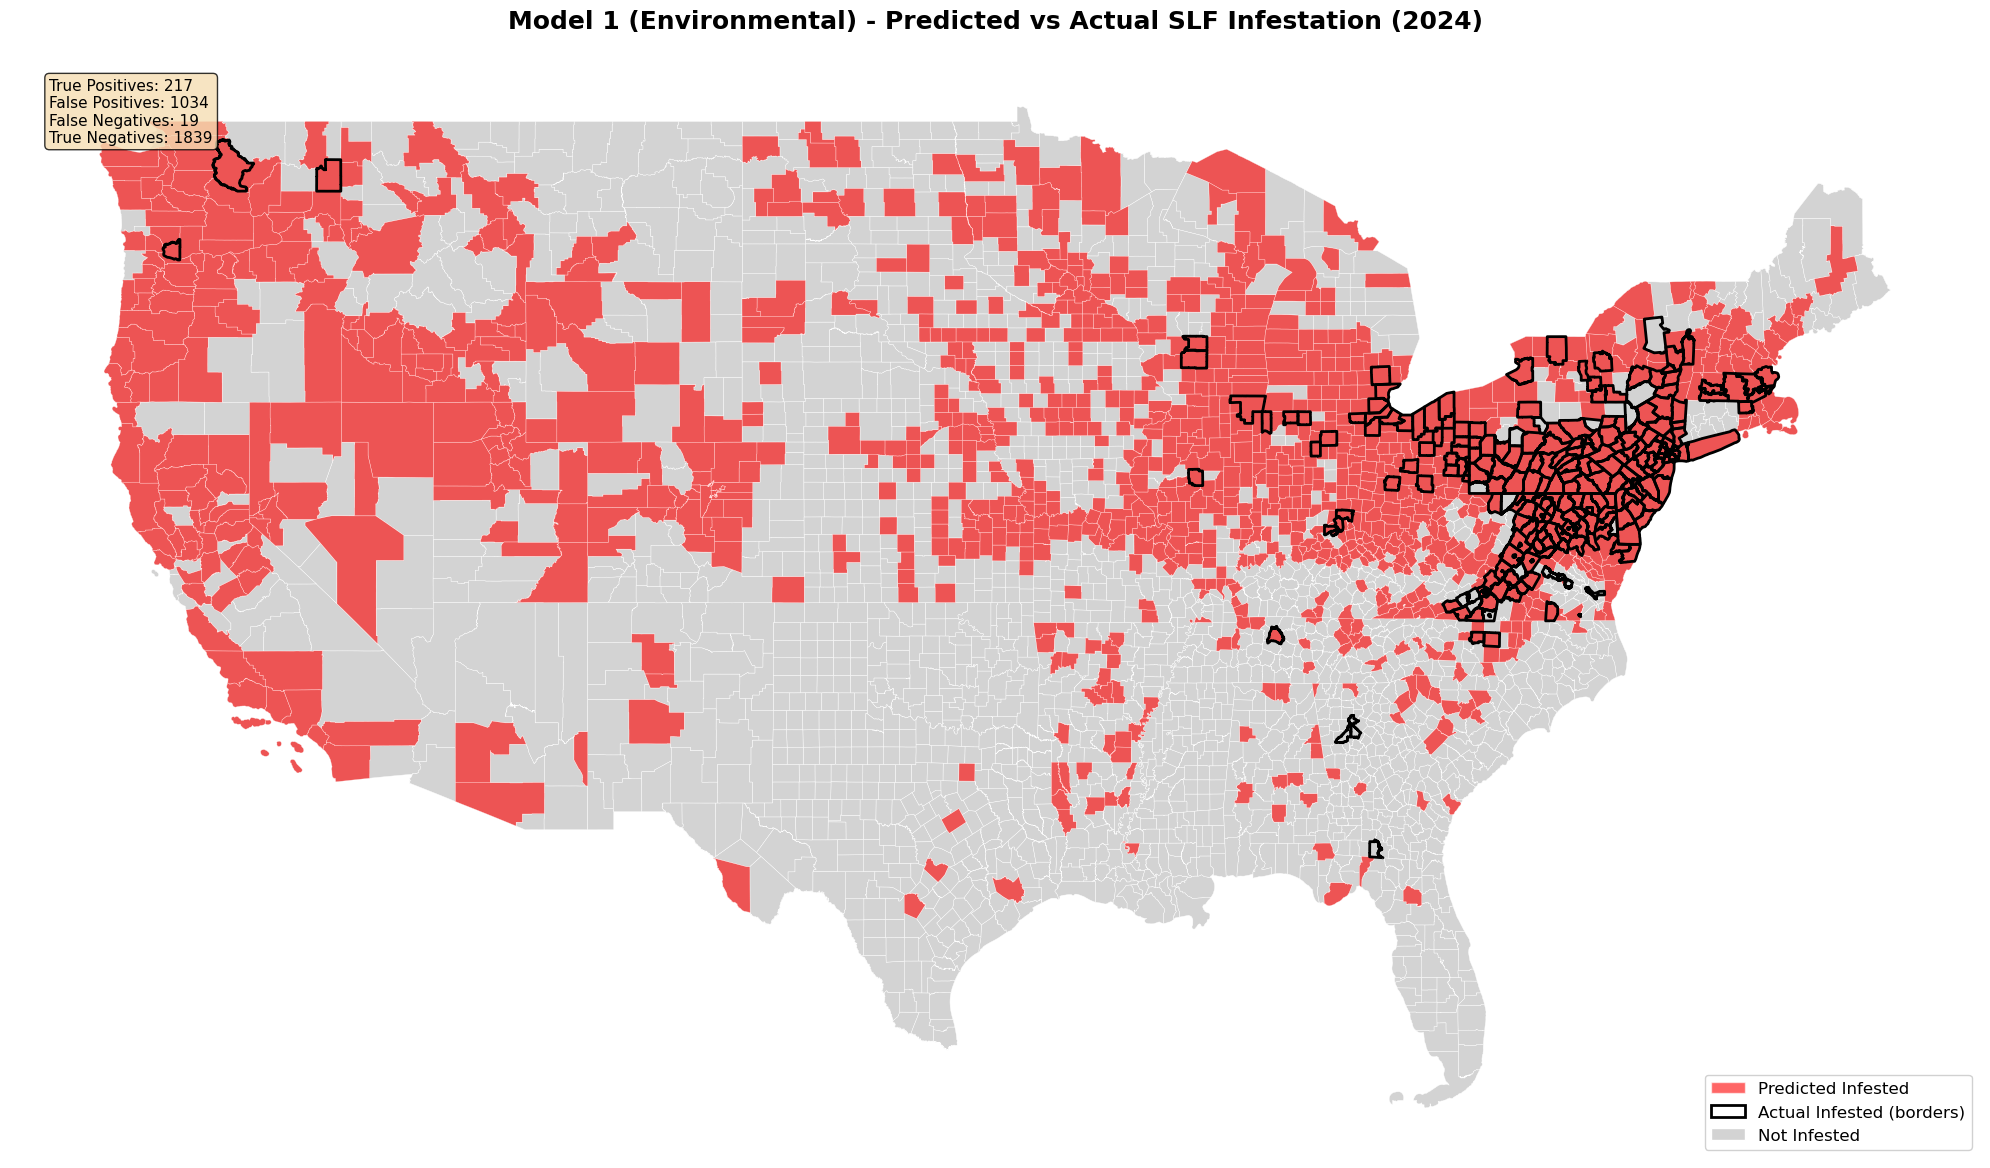

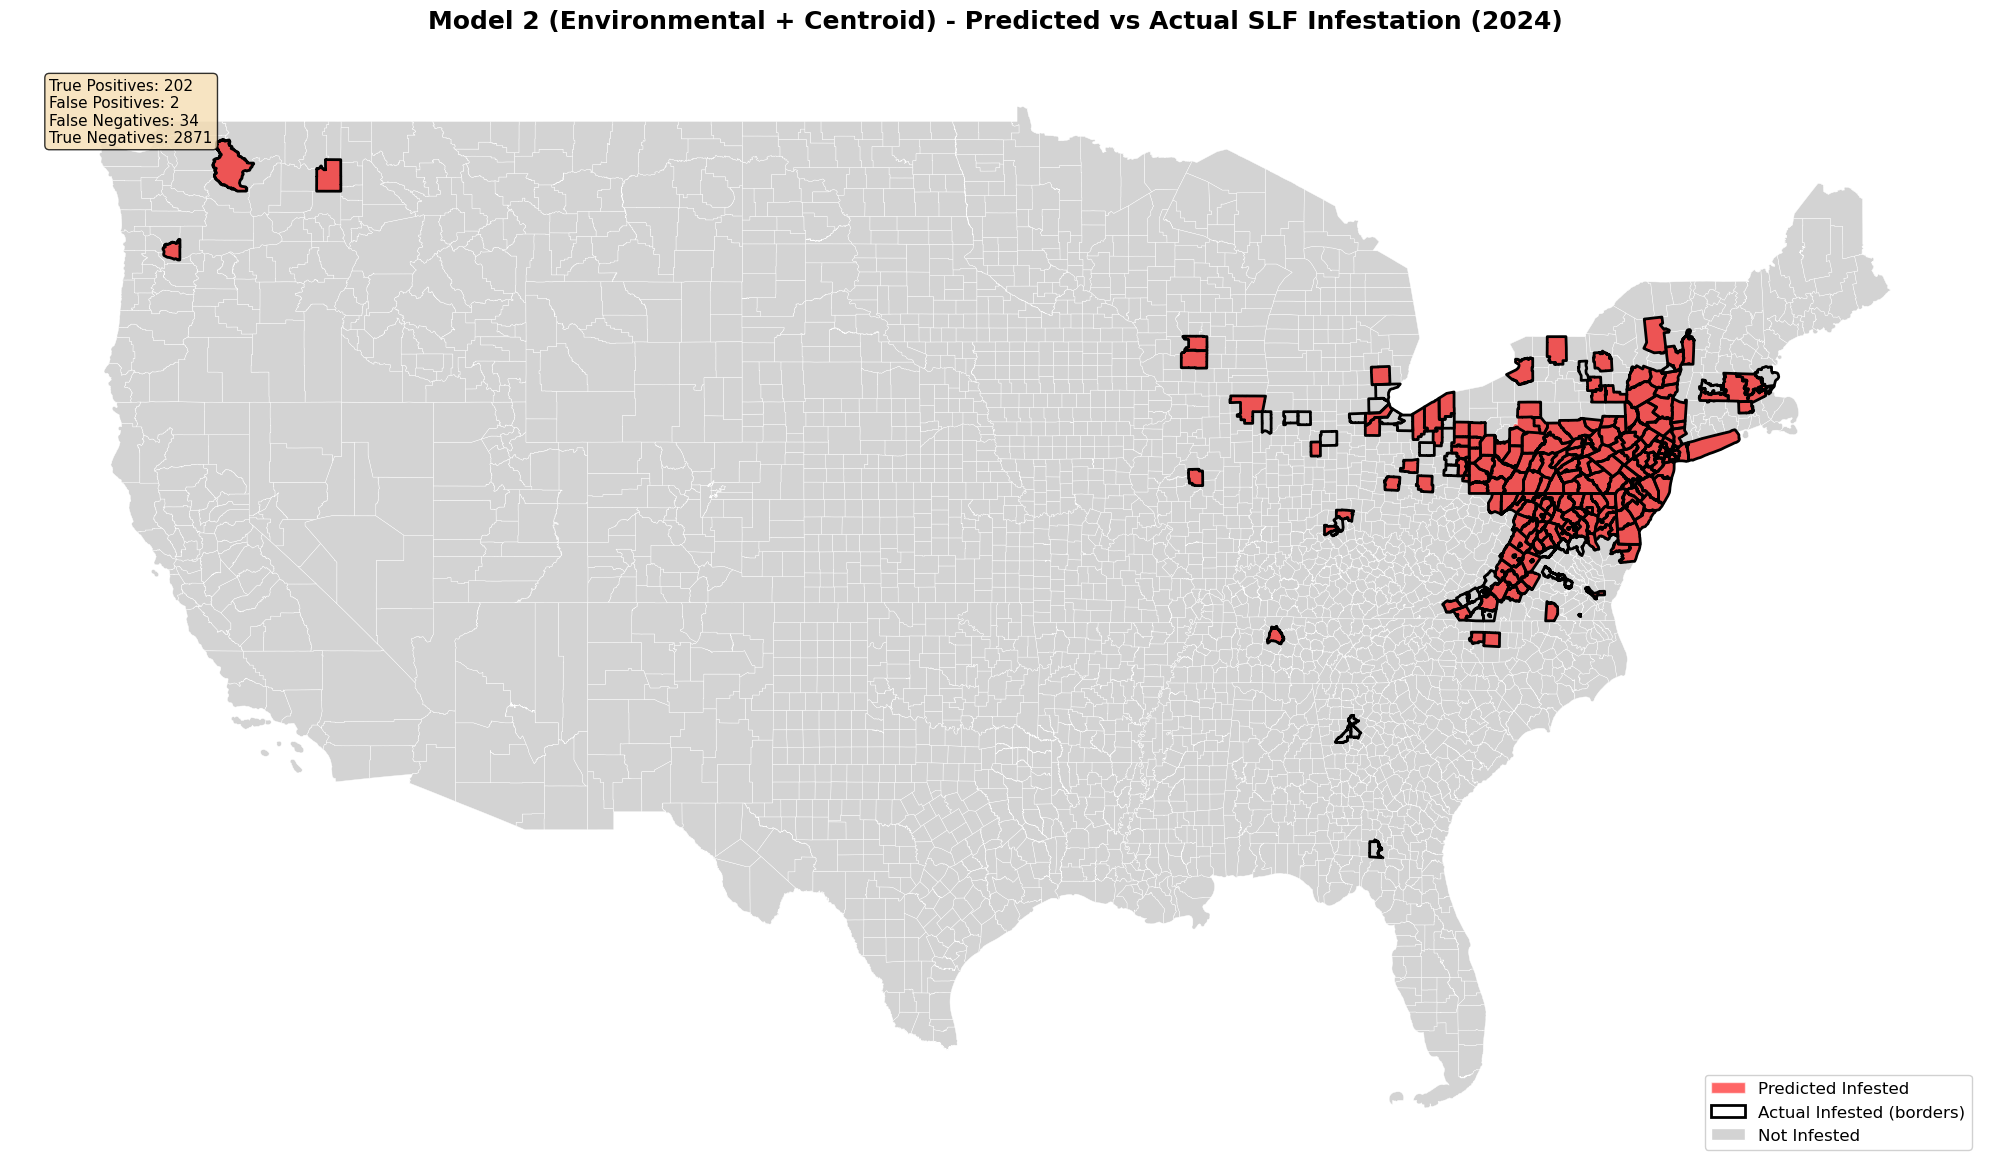

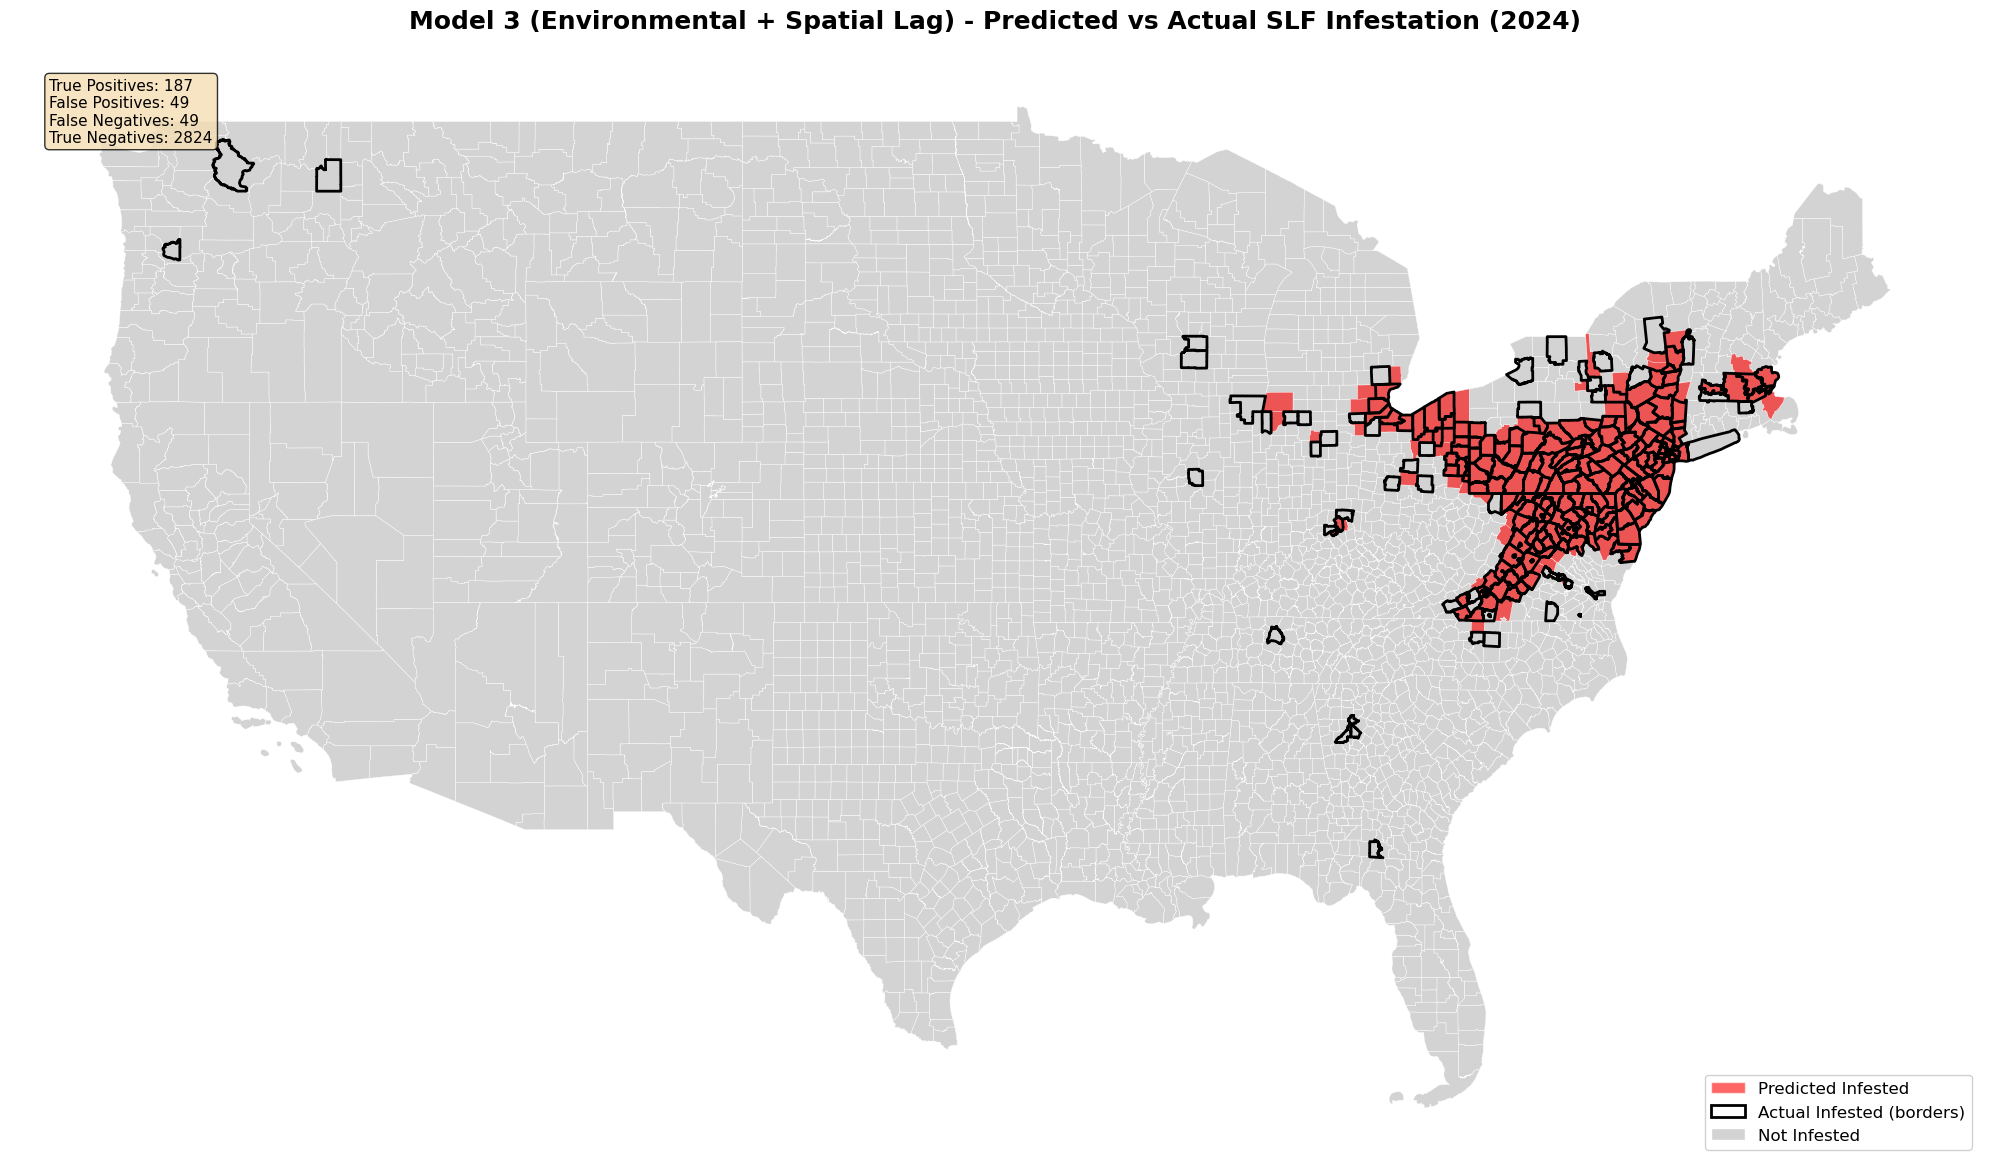

In [14]:
#map test years

fig_m1_2024 = create_prediction_map(
    "Model 1 (Environmental)",
    y_pred_m1,
    test_data,
    counties_viz,
    2024
)
fig_m2_2024 = create_prediction_map(
    "Model 2 (Environmental + Centroid)",
    y_pred_m2,
    test_data,
    counties_viz,
    2024
)
fig_m3_2024 = create_prediction_map(
    "Model 3 (Environmental + Spatial Lag)",
    y_pred_m3,
    test_data,
    counties_viz,
    2024
)

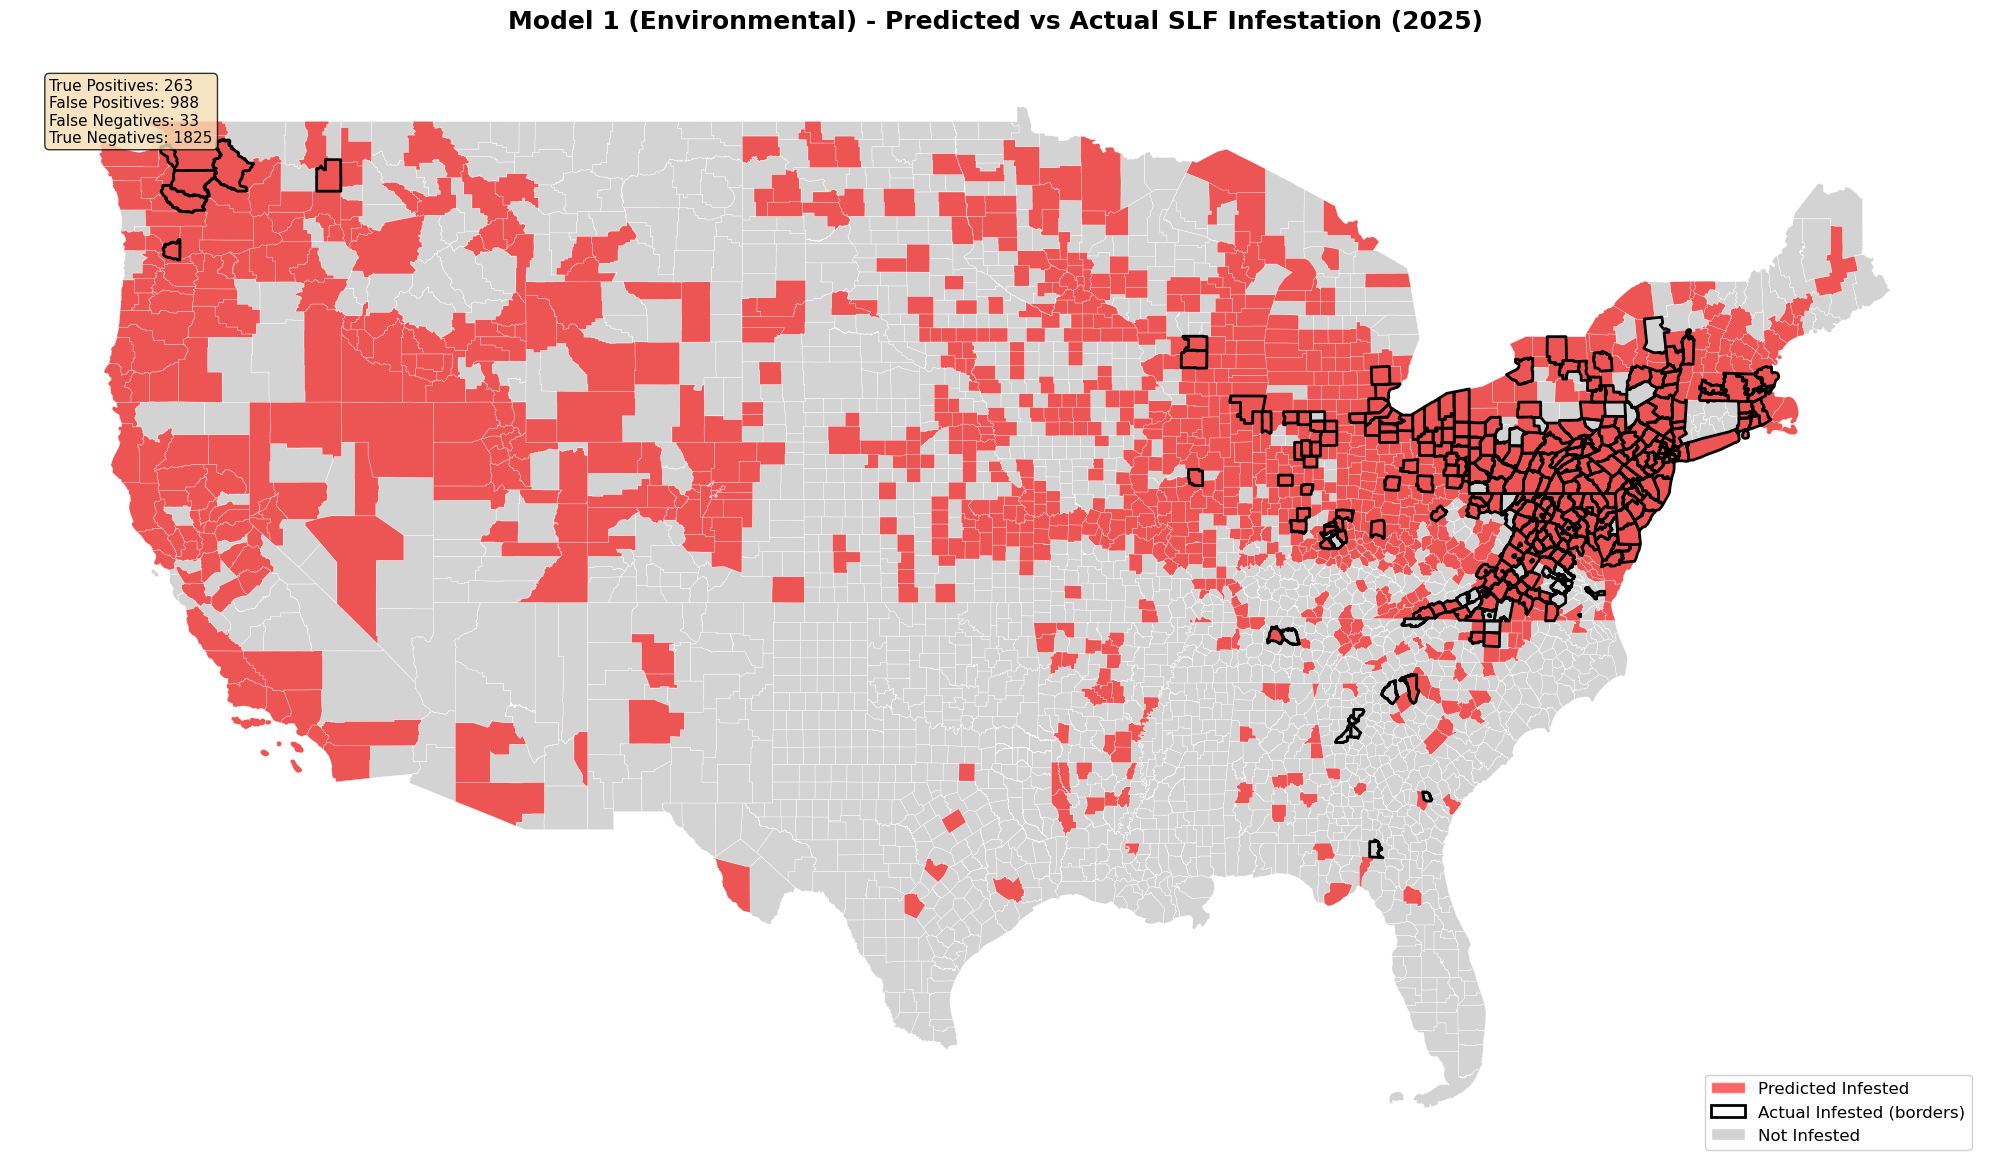

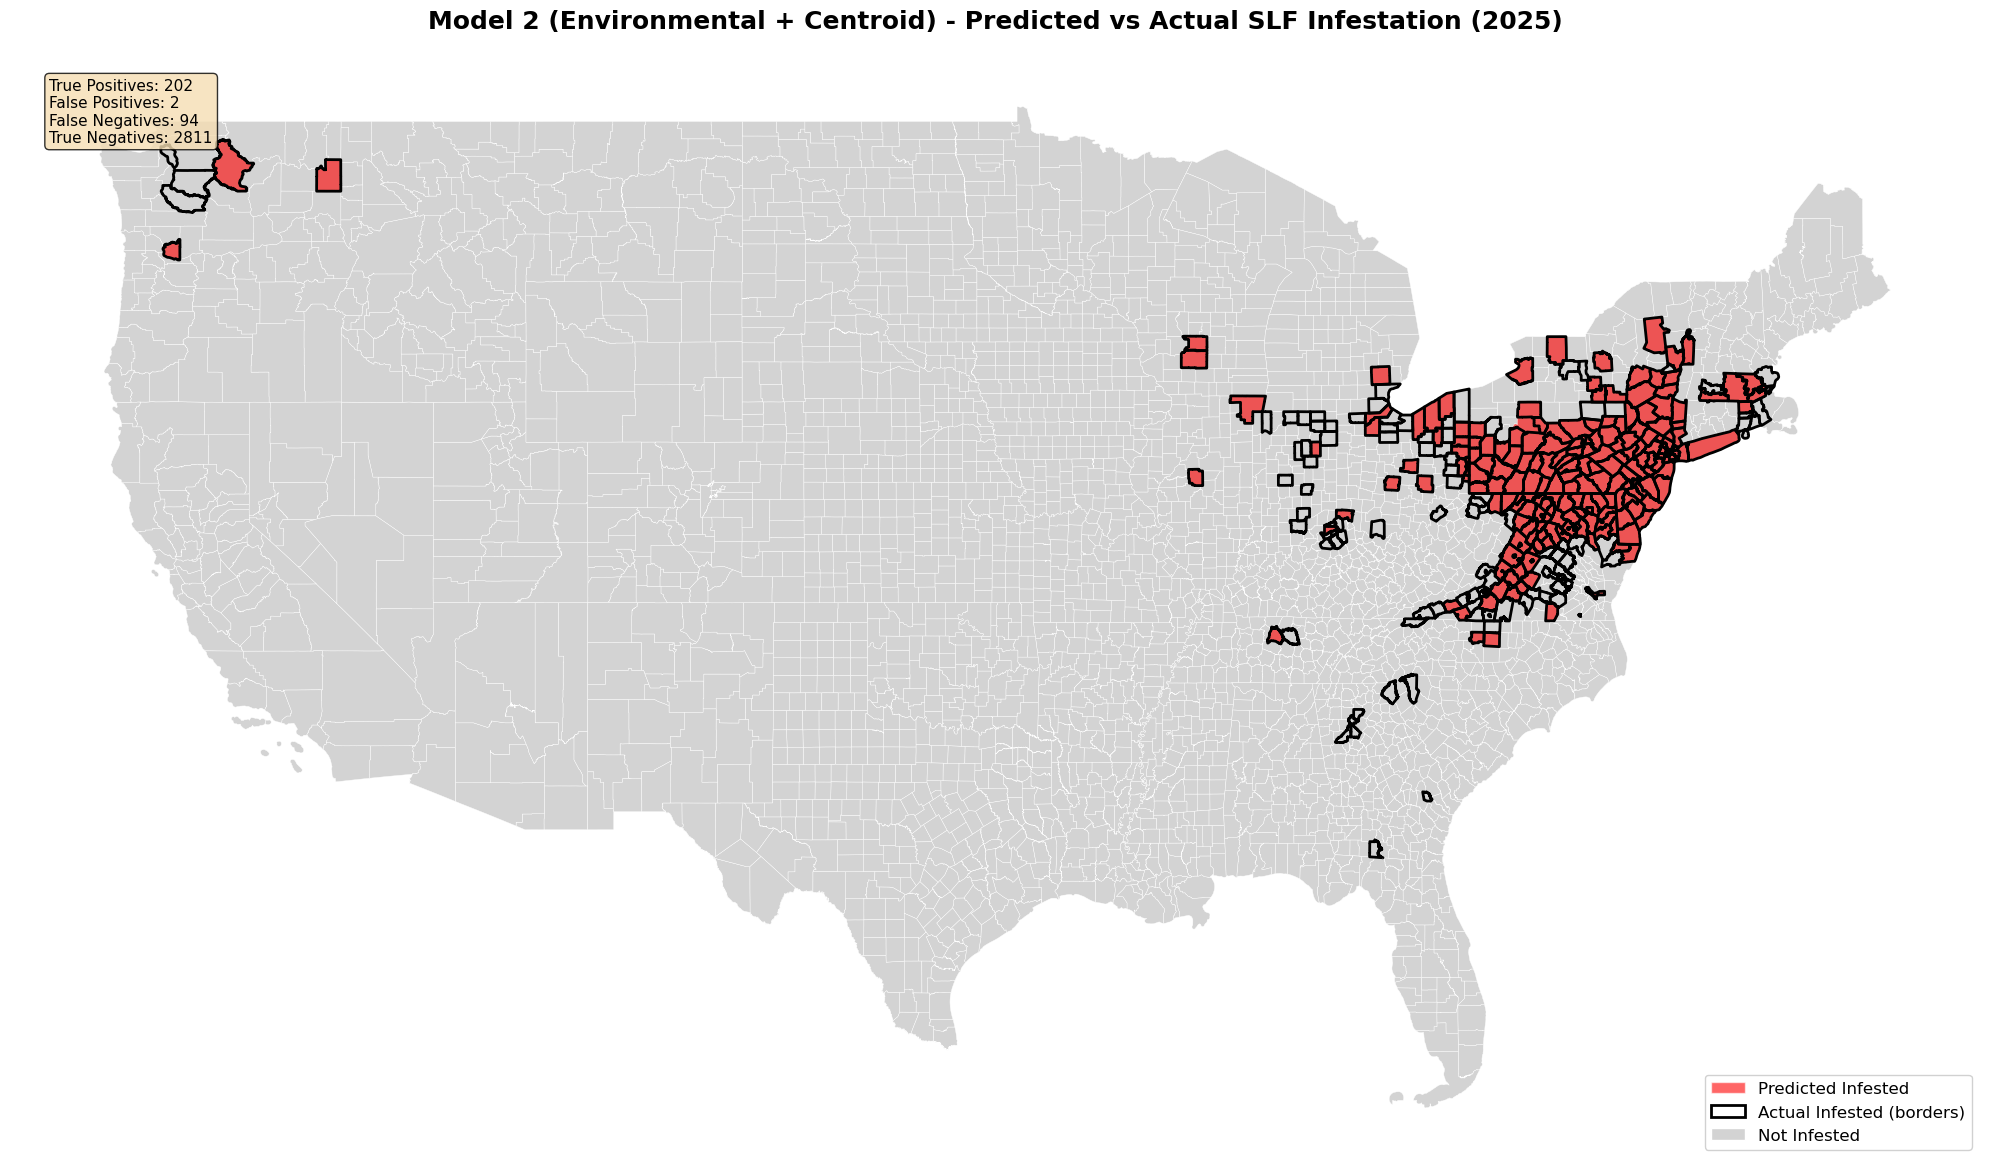

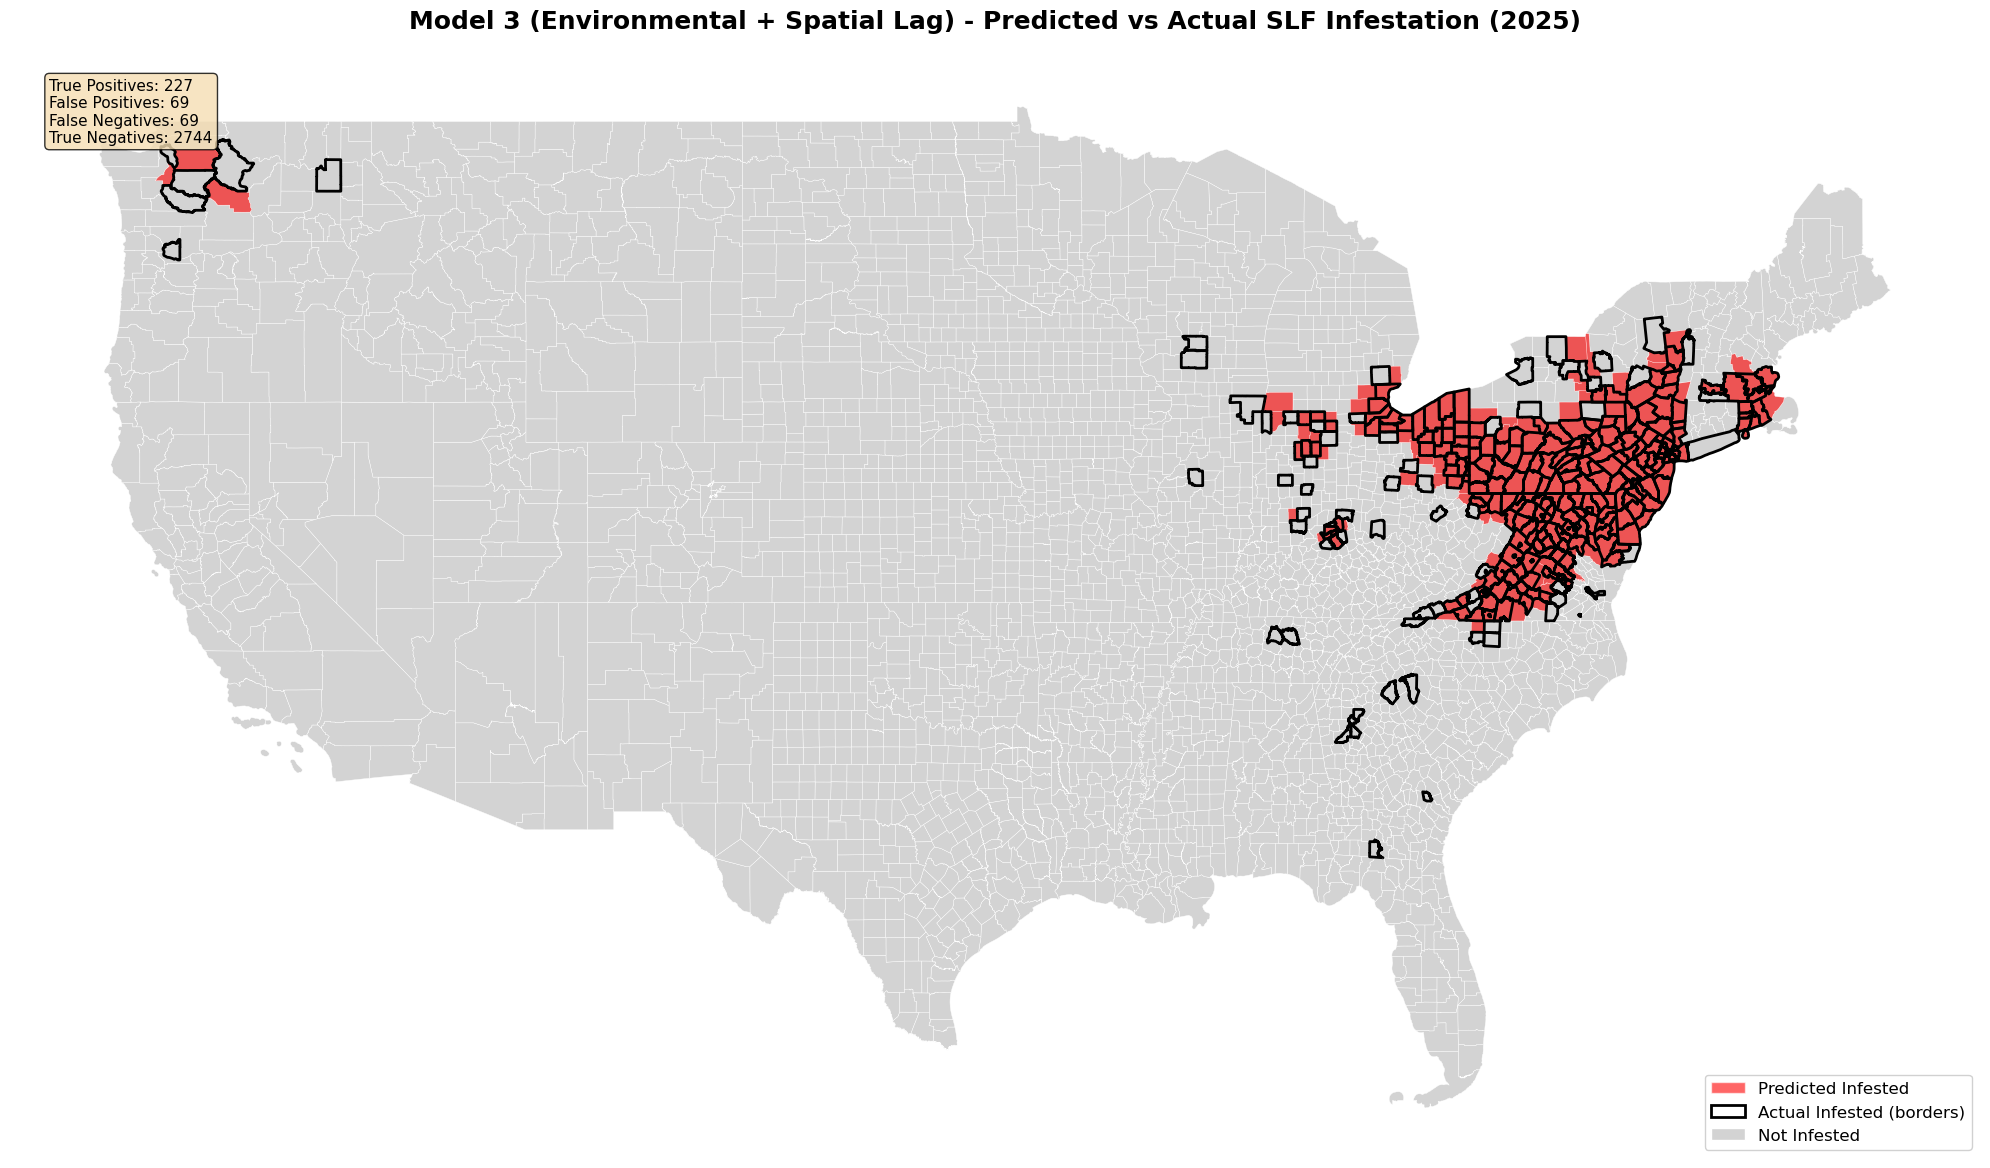

In [15]:
#maps for 2025
fig_m1_2025 = create_prediction_map(
    "Model 1 (Environmental)",
    y_pred_m1,
    test_data,
    counties_viz,
    2025
)

fig_m2_2025 = create_prediction_map(
    "Model 2 (Environmental + Centroid)",
    y_pred_m2,
    test_data,
    counties_viz,
    2025
)

fig_m3_2025 = create_prediction_map(
    "Model 3 (Environmental + Spatial Lag)",
    y_pred_m3,
    test_data,
    counties_viz,
    2025
)



roc-auc scores:
  Model 1: 0.8670
  Model 2: 0.9676
  Model 3: 0.9452


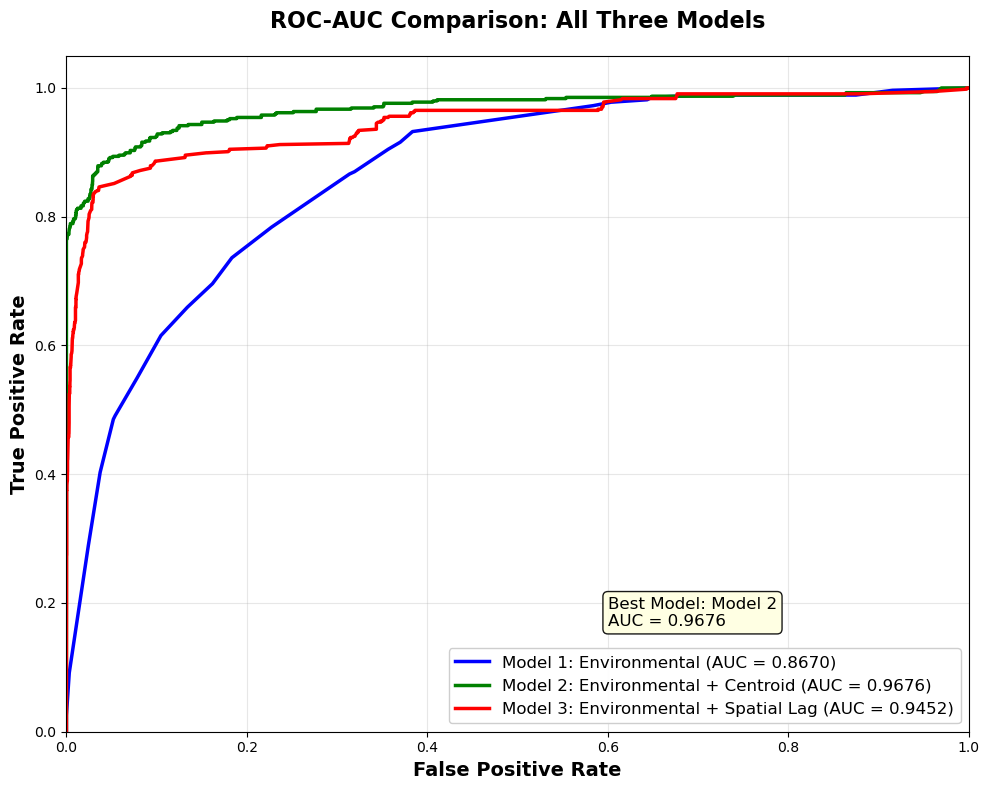

In [16]:
#roc auc curves

# calculate roc
fpr_m1, tpr_m1, _ = roc_curve(y_test_m1, y_pred_proba_m1)
roc_auc_m1 = auc(fpr_m1, tpr_m1)

fpr_m2, tpr_m2, _ = roc_curve(y_test_m2, y_pred_proba_m2)
roc_auc_m2 = auc(fpr_m2, tpr_m2)

fpr_m3, tpr_m3, _ = roc_curve(y_test_m3, y_pred_proba_m3)
roc_auc_m3 = auc(fpr_m3, tpr_m3)

print(f"\nroc-auc scores:")
print(f"  Model 1: {roc_auc_m1:.4f}")
print(f"  Model 2: {roc_auc_m2:.4f}")
print(f"  Model 3: {roc_auc_m3:.4f}")


fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.plot(fpr_m1, tpr_m1, color='blue', linewidth=2.5,
        label=f'Model 1: Environmental (AUC = {roc_auc_m1:.4f})')

ax.plot(fpr_m2, tpr_m2, color='green', linewidth=2.5,
        label=f'Model 2: Environmental + Centroid (AUC = {roc_auc_m2:.4f})')

ax.plot(fpr_m3, tpr_m3, color='red', linewidth=2.5,
        label=f'Model 3: Environmental + Spatial Lag (AUC = {roc_auc_m3:.4f})')



ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax.set_title('ROC-AUC Comparison: All Three Models',
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=12, framealpha=0.95)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])


best_model = max([('Model 1', roc_auc_m1), ('Model 2', roc_auc_m2), ('Model 3', roc_auc_m3)],
                 key=lambda x: x[1])
text_str = f'Best Model: {best_model[0]}\nAUC = {best_model[1]:.4f}'
ax.text(0.6, 0.2, text_str, transform=ax.transAxes,
        fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()


plt.show()



Feature Importance Spatial Lag Model:
           Feature  Importance
4      spatial_lag    0.586395
1   tree_of_heaven    0.148916
3  urban_effective    0.127234
2       urban_code    0.074329
0             year    0.063126


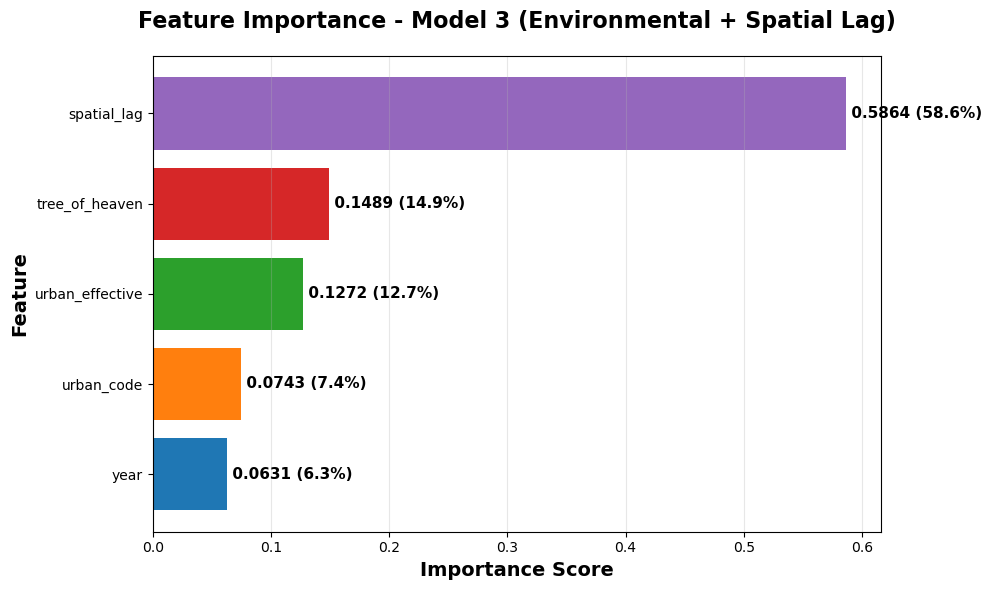

In [17]:
#feature importance for spatial lag model


feature_names = ['year', 'tree_of_heaven', 'urban_code', 'urban_effective', 'spatial_lag']
feature_importance = model3.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=True)  

print("\nFeature Importance Spatial Lag Model:")
print(importance_df.sort_values('Importance', ascending=False))

# percentage importance
importance_df['Importance_Percent'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100


fig, ax = plt.subplots(1, 1, figsize=(10, 6))
bars = ax.barh(importance_df['Feature'], importance_df['Importance'],
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

for i, (bar, importance, pct) in enumerate(zip(bars, importance_df['Importance'],
                                                 importance_df['Importance_Percent'])):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
            f' {importance:.4f} ({pct:.1f}%)',
            va='center', fontsize=11, fontweight='bold')

ax.set_xlabel('Importance Score', fontsize=14, fontweight='bold')
ax.set_ylabel('Feature', fontsize=14, fontweight='bold')
ax.set_title('Feature Importance - Model 3 (Environmental + Spatial Lag)',
             fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()

plt.show()


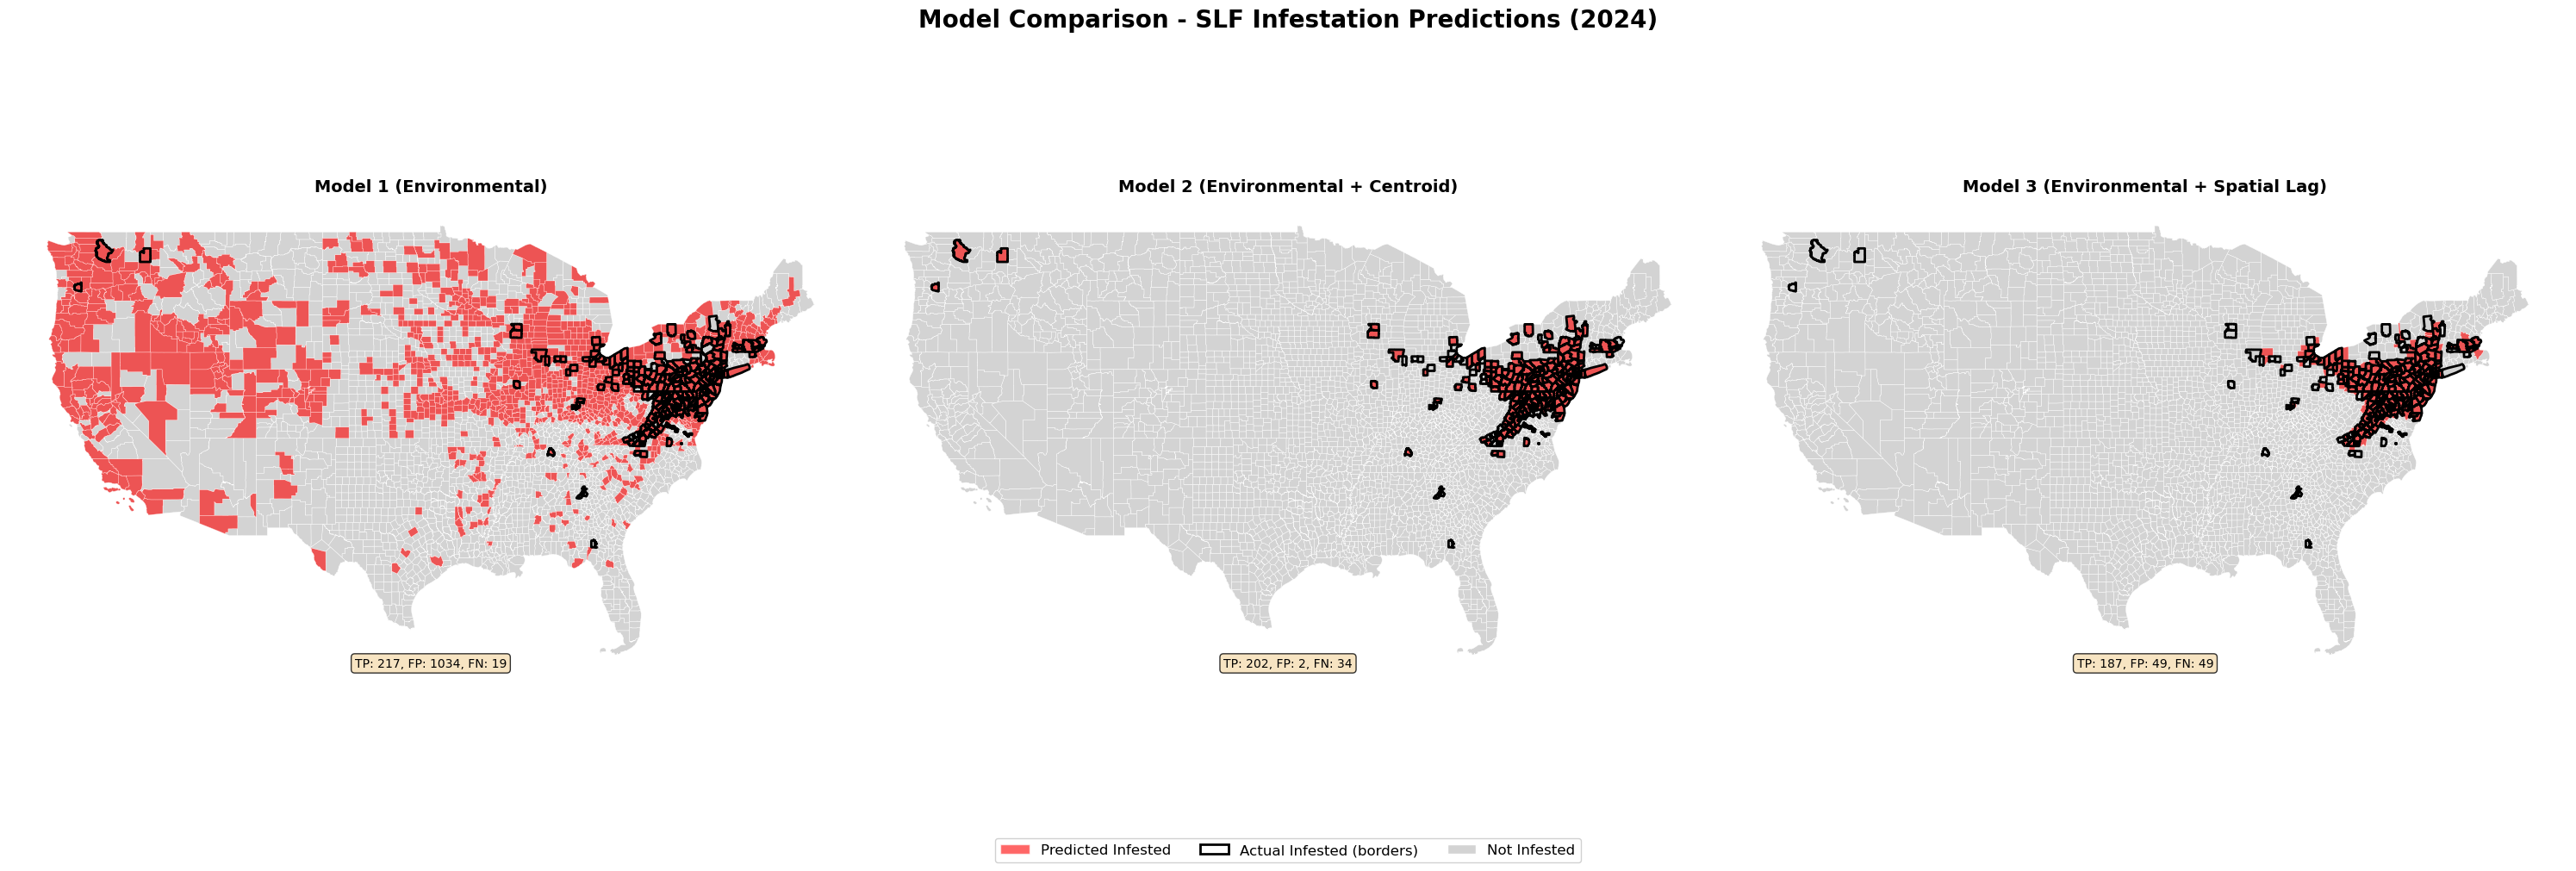

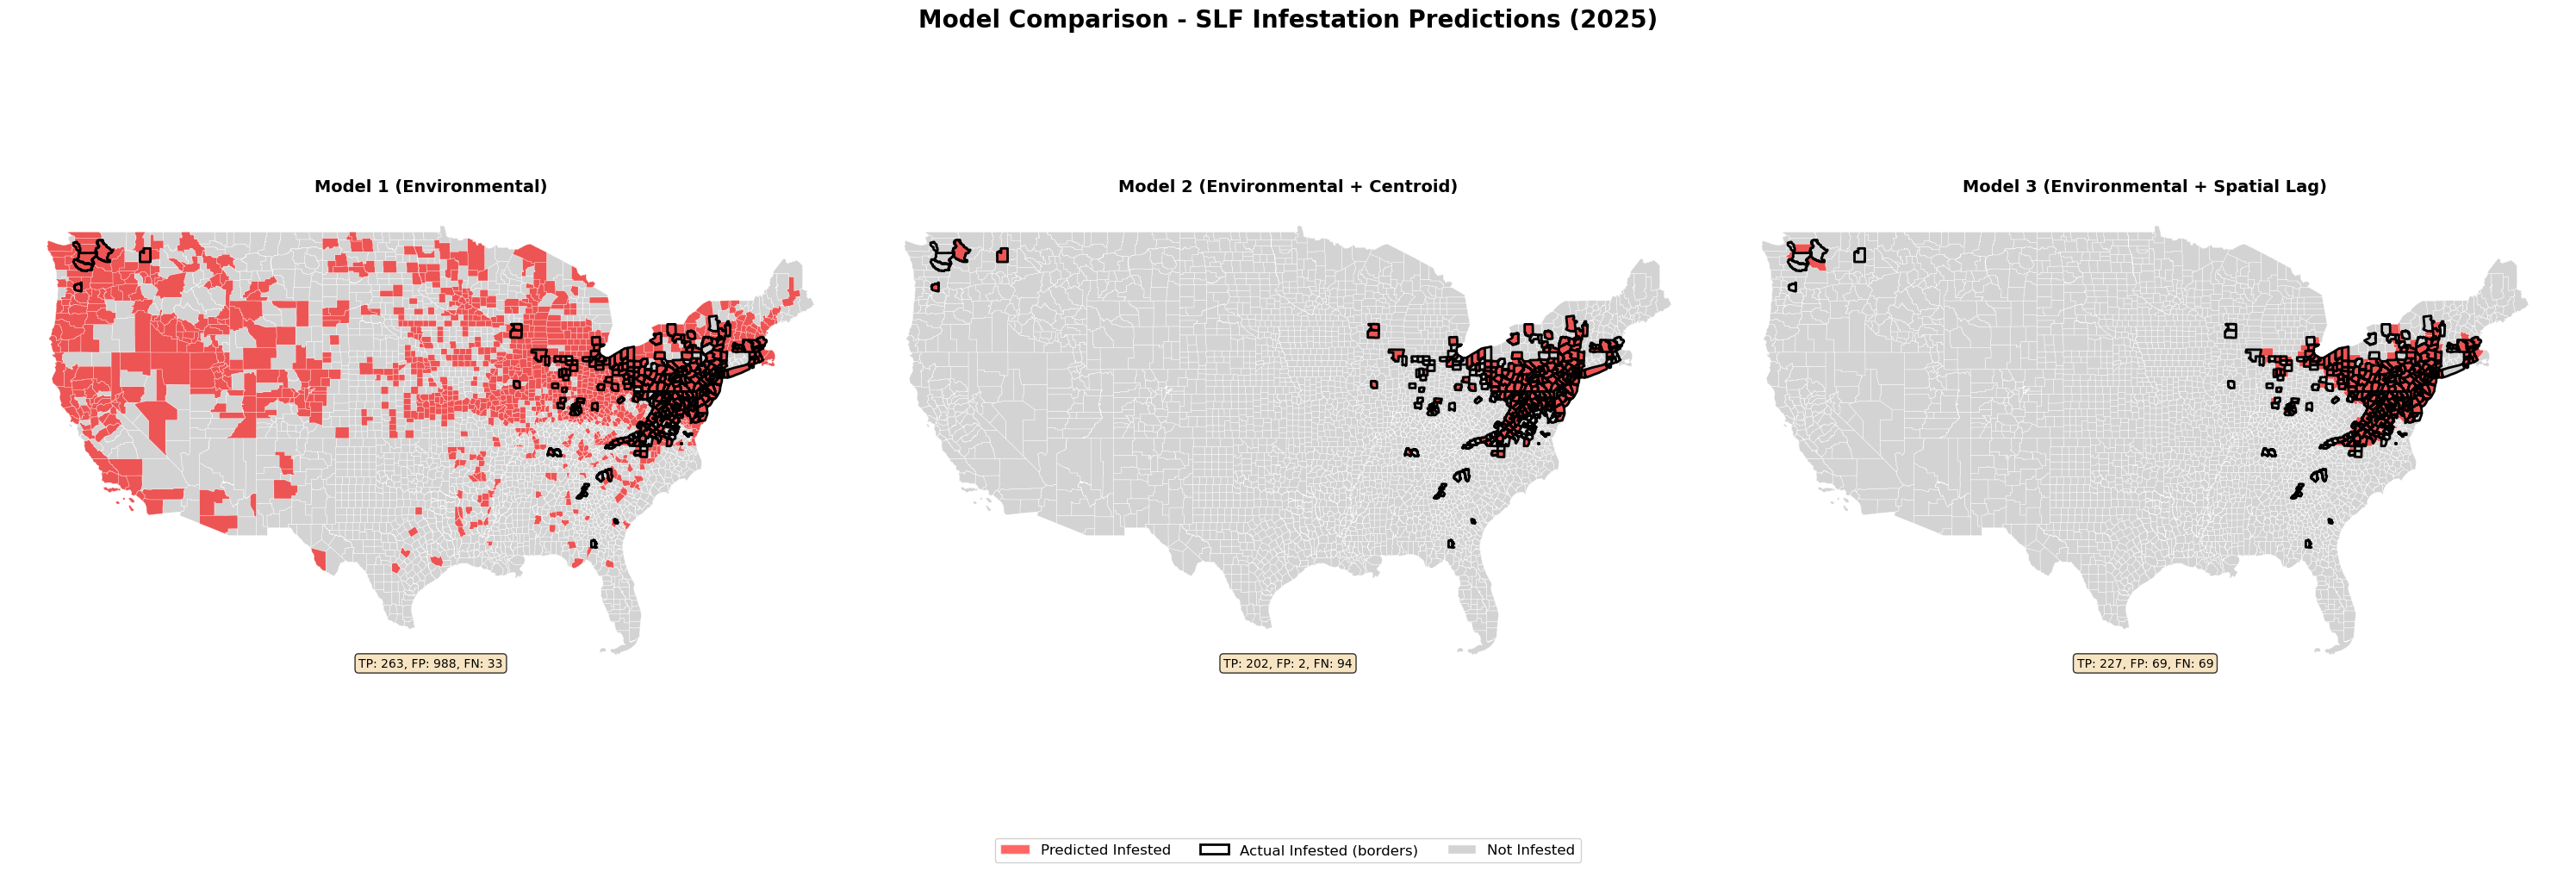

In [24]:
#side by side maps

def create_comparison_map(year):
    fig, axes = plt.subplots(1, 3, figsize=(30, 10))

    models = [
        ("Model 1 (Environmental)", y_pred_m1),
        ("Model 2 (Environmental + Centroid)", y_pred_m2),
        ("Model 3 (Environmental + Spatial Lag)", y_pred_m3)
    ]

    for idx, (model_name, y_pred) in enumerate(models):
        ax = axes[idx]

        #filter out test data for a year
        year_test = test_data[test_data['year'] == year].copy()
        year_pred = y_pred[test_data['year'] == year]

        #add predictions
        year_test['predicted'] = year_pred

        #merge with county shapefile
        counties_map = counties_viz.merge(
            year_test[['fips', 'infested', 'predicted']],
            on='fips',
            how='left'
        )

        #fill nan
        counties_map['infested'] = counties_map['infested'].fillna(0)
        counties_map['predicted'] = counties_map['predicted'].fillna(0)

     
        counties_map.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.3)
        predicted_infested = counties_map[counties_map['predicted'] == 1]
        predicted_infested.plot(ax=ax, color='red', alpha=0.6, edgecolor='white', linewidth=0.3)
        actual_infested = counties_map[counties_map['infested'] == 1]
        actual_infested.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)

        # stats
        tp = ((counties_map['infested'] == 1) & (counties_map['predicted'] == 1)).sum()
        fp = ((counties_map['infested'] == 0) & (counties_map['predicted'] == 1)).sum()
        fn = ((counties_map['infested'] == 1) & (counties_map['predicted'] == 0)).sum()

        
        ax.set_title(f'{model_name}', fontsize=14, fontweight='bold', pad=10)
        ax.axis('off')

        stats_text = f'TP: {tp}, FP: {fp}, FN: {fn}'
        ax.text(0.5, 0.02, stats_text, transform=ax.transAxes,
                fontsize=10, ha='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

 
    fig.suptitle(f'Model Comparison - SLF Infestation Predictions ({year})',
                 fontsize=20, fontweight='bold', y=0.98)

    legend_elements = [
        Patch(facecolor='red', alpha=0.6, edgecolor='white', label='Predicted Infested'),
        Patch(facecolor='none', edgecolor='black', linewidth=2, label='Actual Infested (borders)'),
        Patch(facecolor='lightgray', edgecolor='white', label='Not Infested')
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=12,
               framealpha=0.9, bbox_to_anchor=(0.5, -0.02))

    plt.tight_layout()

    plt.show()

    return fig

comparison_2024 = create_comparison_map(2024)
comparison_2025 = create_comparison_map(2025)

In [26]:
#prepare data for forecasting


#thresholds
FORECAST_PROB_THRESHOLD = 0.7
FORECAST_SPATIAL_LAG_THRESHOLD = 0.4


baseline_year = 2025
forecast_start_year = 2026
forecast_end_year = 2035
forecast_years = list(range(forecast_start_year, forecast_end_year + 1))


#start at 2025
baseline_data = features[features['year'] == baseline_year].copy()

baseline_data['fips'] = baseline_data['fips'].astype(str).str.zfill(5)

print(f"\n2025 infested counties: {baseline_data['infested'].sum()}")
print(f"2025 total counties: {len(baseline_data)}")


2025 infested counties: 303
2025 total counties: 3109


In [27]:
#iterative forecasting loop

#store all forecasted data
forecast_results = []

#initialize with baseline data
current_year_data = baseline_data.copy()

# get neighbor relationhsips
counties_forecast = gpd.read_file("CS4824CapstoneData/tl_2025_us_county/tl_2025_us_county.shp")
continental_state_fips = [f"{i:02d}" for i in range(1, 57) if i not in [2, 15]]
counties_forecast = counties_forecast[counties_forecast['STATEFP'].isin(continental_state_fips)].copy()
counties_forecast['fips'] = counties_forecast['GEOID'].astype(str).str.zfill(5)


#rebuild neighbor relationships
county_neighbors = {}
for idx, county in counties_forecast.iterrows():
    fips_code = county['fips']
    county_geom = county.geometry
    neighbors = counties_forecast[counties_forecast.geometry.touches(county_geom)]['fips'].tolist()
    county_neighbors[fips_code] = neighbors


#verify fips match
baseline_fips = set(baseline_data['fips'].unique())
neighbor_fips = set(county_neighbors.keys())
fips_match = len(baseline_fips.intersection(neighbor_fips))

#forecast each year
for year in forecast_years:
    print(f"\n Forecasting Year {year}")

    # create this years data
    year_data = current_year_data[['fips','tree_of_heaven', 'urban_code', 'urban_effective',
                                     'centroid_lat', 'centroid_lon', 'infested']].copy()
    year_data['year'] = year

    #recalculate spatial lag
    spatial_lag_list = []

    infested_lookup = dict(zip(year_data['fips'], year_data['infested']))

    for fips_code in year_data['fips'].unique():
        neighbors = county_neighbors.get(fips_code, [])

        if len(neighbors) == 0:
            spatial_lag = 0.0
        else:
            neighbor_infested_count = sum([infested_lookup.get(n, 0) for n in neighbors])
            spatial_lag = neighbor_infested_count / len(neighbors)

        spatial_lag_list.append({
            'fips': fips_code,
            'spatial_lag': spatial_lag
        })

    spatial_lag_df = pd.DataFrame(spatial_lag_list)

    # add spatial lag to year data
    year_data = year_data.merge(spatial_lag_df, on='fips', how='left')

    print(f"  Spatial lag mean: {year_data['spatial_lag'].mean():.3f}, max: {year_data['spatial_lag'].max():.3f}")
    print(f"  Counties with spatial_lag > 0: {(year_data['spatial_lag'] > 0).sum()}")

    #prepare features for prediction
    model3_features = ['year', 'tree_of_heaven', 'urban_code', 'urban_effective', 'spatial_lag']
    X_forecast = year_data[model3_features].copy()

    y_pred_proba = model3.predict_proba(X_forecast)[:, 1]

    # apply constraints
    y_pred = ((y_pred_proba >= FORECAST_PROB_THRESHOLD) &
              (year_data['spatial_lag'] >= FORECAST_SPATIAL_LAG_THRESHOLD)).astype(int)

    
    previously_infested = year_data['infested'].copy()

    #once infested a county remains infested
    year_data['infested'] = np.maximum(year_data['infested'], y_pred)

    # track new infested counties
    year_data['predicted_new'] = ((previously_infested == 0) & (year_data['infested'] == 1)).astype(int)

    newly_infested_count = year_data['predicted_new'].sum()

    print(f"  Total infested: {year_data['infested'].sum()}")
    print(f"  Newly infested: {newly_infested_count}")


    year_data['forecast_year'] = year
    forecast_results.append(year_data.copy())

    # update current year with new infestations for next iteration
    current_year_data = year_data.copy()


# combine results
df_forecast = pd.concat(forecast_results, ignore_index=True)

print(f"\ndf_forecast shape: {df_forecast.shape}")
print(f"Years in forecast: {sorted(df_forecast['year'].unique())}")



 Forecasting Year 2026
  Spatial lag mean: 0.102, max: 1.000
  Counties with spatial_lag > 0: 610
  Total infested: 372
  Newly infested: 69

 Forecasting Year 2027
  Spatial lag mean: 0.121, max: 1.000
  Counties with spatial_lag > 0: 631
  Total infested: 415
  Newly infested: 43

 Forecasting Year 2028
  Spatial lag mean: 0.134, max: 1.000
  Counties with spatial_lag > 0: 653
  Total infested: 454
  Newly infested: 39

 Forecasting Year 2029
  Spatial lag mean: 0.148, max: 1.000
  Counties with spatial_lag > 0: 673
  Total infested: 488
  Newly infested: 34

 Forecasting Year 2030
  Spatial lag mean: 0.158, max: 1.000
  Counties with spatial_lag > 0: 685
  Total infested: 512
  Newly infested: 24

 Forecasting Year 2031
  Spatial lag mean: 0.166, max: 1.000
  Counties with spatial_lag > 0: 698
  Total infested: 528
  Newly infested: 16

 Forecasting Year 2032
  Spatial lag mean: 0.171, max: 1.000
  Counties with spatial_lag > 0: 708
  Total infested: 543
  Newly infested: 15

 Fore

In [28]:
#summary stats

summary_stats = df_forecast.groupby('year').agg({
    'infested': 'sum',
    'predicted_new': 'sum'
}).round(0)

summary_stats.columns = ['Total Infested', 'Newly Infested']

print("\nInfestation growth:")
print(summary_stats)

#calculate growth rate
total_infested_2025 = baseline_data['infested'].sum()
total_infested_2035 = df_forecast[df_forecast['year'] == 2035]['infested'].sum()
total_growth = total_infested_2035 - total_infested_2025
growth_rate = (total_growth / total_infested_2025) * 100

print(f"\nForecast summary:")
print(f"  Starting: {total_infested_2025} counties")
print(f"  Ending: {total_infested_2035} counties")
print(f"  Total growth: {total_growth} counties ({growth_rate:.1f}%)")



Infestation growth:
      Total Infested  Newly Infested
year                                
2026             372              69
2027             415              43
2028             454              39
2029             488              34
2030             512              24
2031             528              16
2032             543              15
2033             559              16
2034             571              12
2035             580               9

Forecast summary:
  Starting: 303 counties
  Ending: 580 counties
  Total growth: 277 counties (91.4%)


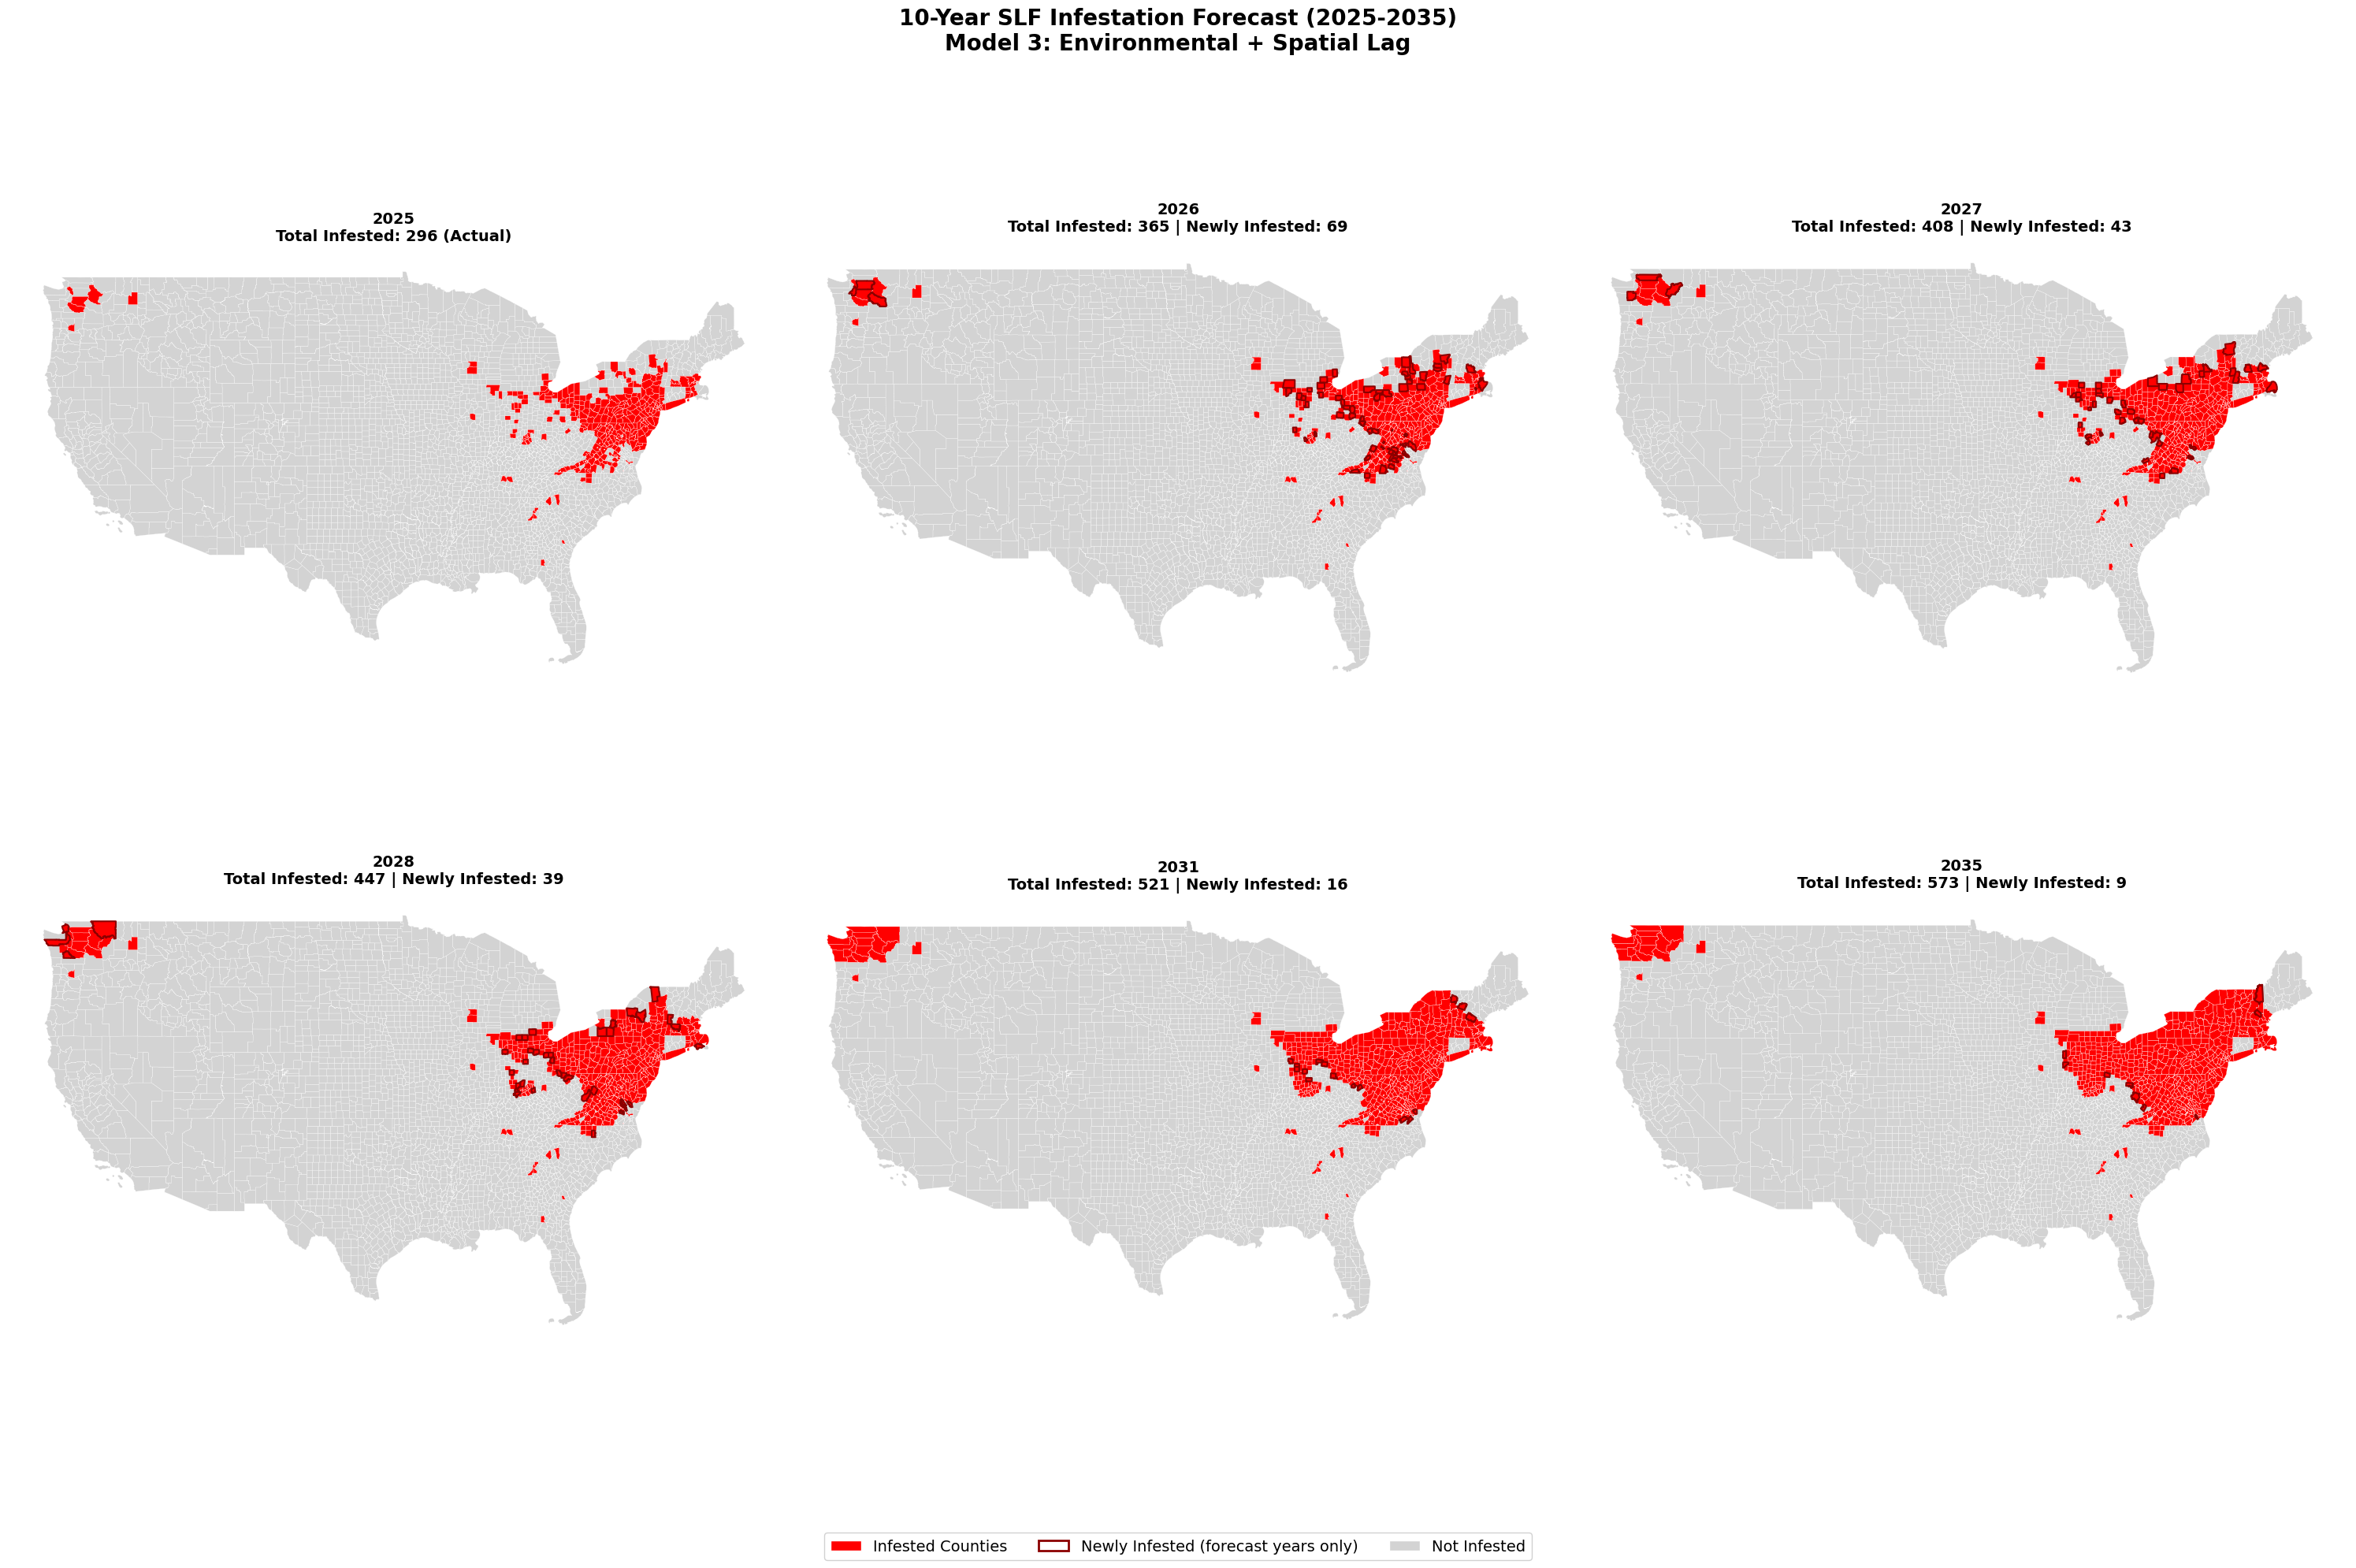

In [29]:
#visualization of forecast


years_to_plot = [2025, 2026, 2027, 2028, 2031, 2035]
year_labels = ['2025', '2026', '2027',
               '2028', '2031', '2035']

df_forecast['fips'] = df_forecast['fips'].astype(str).str.zfill(5)
baseline_data['fips'] = baseline_data['fips'].astype(str).str.zfill(5)

fig, axes = plt.subplots(2, 3, figsize=(30, 20))
axes = axes.flatten()

for idx, (year, label) in enumerate(zip(years_to_plot, year_labels)):
    ax = axes[idx]

    #get data for current year
    if year == 2025:
        # baseline is 2025
        year_data = baseline_data.copy()
        year_data['predicted_new'] = 0 
    else:
        year_data = df_forecast[df_forecast['year'] == year].copy()


    counties_map = counties_forecast.merge(
        year_data[['fips', 'infested', 'predicted_new']],
        on='fips',
        how='left'
    )

    #fill nan with 0
    counties_map['infested'] = counties_map['infested'].fillna(0)
    counties_map['predicted_new'] = counties_map['predicted_new'].fillna(0)


    counties_map[counties_map['infested'] == 0].plot(
        ax=ax, color='lightgray', edgecolor='white', linewidth=0.2
    )

    counties_map[counties_map['infested'] == 1].plot(
        ax=ax, color='red', edgecolor='white', linewidth=0.2
    )

    if year > 2025:
        newly_infested_map = counties_map[counties_map['predicted_new'] == 1]
        if len(newly_infested_map) > 0:
            newly_infested_map.plot(
                ax=ax, facecolor='none', edgecolor='darkred', linewidth=1.5
            )

    total_infested = (counties_map['infested'] == 1).sum()
    newly_infested_count = (counties_map['predicted_new'] == 1).sum()

    if year == 2025:
        ax.set_title(f'{label}\nTotal Infested: {total_infested} (Actual)',
                     fontsize=14, fontweight='bold', pad=10)
    else:
        ax.set_title(f'{label}\nTotal Infested: {total_infested} | Newly Infested: {newly_infested_count}',
                     fontsize=14, fontweight='bold', pad=10)
    ax.axis('off')

fig.suptitle('10-Year SLF Infestation Forecast (2025-2035)\nModel 3: Environmental + Spatial Lag',
             fontsize=20, fontweight='bold', y=0.98)

legend_elements = [
    Patch(facecolor='red', edgecolor='white', label='Infested Counties'),
    Patch(facecolor='none', edgecolor='darkred', linewidth=2, label='Newly Infested (forecast years only)'),
    Patch(facecolor='lightgray', edgecolor='white', label='Not Infested')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=14,
           framealpha=0.9, bbox_to_anchor=(0.5, -0.01))

plt.tight_layout()

plt.show()
